In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [2]:
torch.manual_seed(42)

-----

In [2]:
#load the embedding matrix
import joblib
embedding_dict = joblib.load('embeds.pkl')

word_to_id = joblib.load('word_to_ids.pkl')
id_to_word = joblib.load('idx_to_word.pkl')

In [3]:
embed_dim = 300
embeddings_tensor = torch.tensor([i for i in embedding_dict.values()], dtype=torch.float32)

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_96117/1542511212.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  embeddings_tensor = torch.tensor([i for i in embedding_dict.values()], dtype=torch.float32)


In [4]:
embeddings_tensor.shape

torch.Size([1244025, 300])

In [5]:
#prepare the data for the query tower work on the query triplets
import json
with open('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/data/train_triples_sample.json') as f:
    data = json.load(f)

with open('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/eda/train_triples_v1.1.json') as f:
    train = json.load(f)

with open('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/eda/valid_triples_v1.1.json') as f:
    val = json.load(f)

In [6]:
average_sentence_length = sum(len(item['query'].split()) for item in data) / len(data)
print(average_sentence_length)#this before stemming and removing stopwords
average_context_length = sum(len(item['positive'].split()) for item in data) / len(data)
print(average_context_length)#this before stemming and removing stopwords

12.0
42.8


In [7]:
from tqdm import tqdm
from utils import tokenize
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuliagoryachev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/yuliagoryachev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
df_val = pd.DataFrame(val)
df_train = pd.DataFrame(train)
df_tot = pd.concat([df_val, df_train])
queries = df_tot['query'].unique()
train_q, val_q = train_test_split(queries, test_size=0.2, random_state=42)

train = df_tot[df_tot['query'].isin(train_q)]
val = df_tot[df_tot['query'].isin(val_q)]

train = train[['query', 'positive', 'negative']]
val = val[['query', 'positive', 'negative']]
train = train.to_dict('records')
val = val.to_dict('records')

In [9]:
print(len(train), len(val))

606993 151560


In [10]:
#data preparartion

In [11]:
#convert to indices using the word_to_id dictionary
import joblib
word_to_id = joblib.load('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/eda/word_to_ids.pkl')

In [15]:
SENT_LEN = 12
CONTEXT_LEN = 50
from nltk.stem import PorterStemmer
import constants

punctuation_map = constants.punctuation_map

In [17]:
import numpy as np


query = train[0]['query']
print(query)
query_embed = np.zeros((1, 300))
count_q = 0
for i in tokenize(query, punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True):
    print(i)
    token = word_to_id.get(i, word_to_id['<unk>'])
    query_embed+=embedding_dict.get(token, np.zeros(300))
    print(token)

query_embed = query_embed/max(count_q,1)

print('========')
#embed a positive context
positive_embed = np.zeros((1, 300))
count_p = 0
positive = train[0]['positive']
print(positive)
for i in tokenize(positive, punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True):
    print(i)
    token = word_to_id.get(i, word_to_id['<unk>'])
    positive_embed+=embedding_dict.get(token, np.zeros(300))
    print(token)

positive_embed = positive_embed/max(count_p,1)

print('========')
#embed a negative context
negative_embed = np.zeros((1, 300))
count_p = 0
negative = train[0]['negative']
print(negative)
for i in tokenize(negative, punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True):
    print(i)
    token = word_to_id.get(i, word_to_id['<unk>'])
    negative_embed+=embedding_dict.get(token, np.zeros(300))
    print(token)

negative_embed = negative_embed/max(count_p,1)

walgreens store sales average
walgreen
981316
store
730086
sale
345464
averag
327053
The average Walgreens salary ranges from approximately $15,000 per year for Customer Service Associate / Cashier to $179,900 per year for District Manager. Average Walgreens hourly pay ranges from approximately $7.35 per hour for Laboratory Technician to $68.90 per hour for Pharmacy Manager. Salary information comes from 7,810 data points collected directly from employees, users, and jobs on Indeed.
averag
327053
walgreen
981316
salari
689663
rang
749018
approxim
97312
per
1182124
year
254939
custom
366851
servic
422897
associ
419353
cashier
725901
per
1182124
year
254939
district
137275
manag
1200316
averag
327053
walgreen
981316
hourli
1216105
pay
719309
rang
749018
approxim
97312
per
1182124
hour
1113327
laboratori
1106822
technician
1009062
per
1182124
hour
1113327
pharmaci
1130532
manag
1200316
salari
689663
inform
892194
come
33007
data
987252
point
442838
collect
837062
directli
847128
employe
5

In [18]:
#cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(query_embed, positive_embed))
print(cosine_similarity(query_embed, negative_embed))

[[0.3866413]]
[[0.20617133]]


In [19]:
from typing import List
import numpy as np

In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
class QueryDataset(Dataset):
    def __init__(self, data):
        self.queries = [d['query'] for d in data]
        self.positives = [d['positive'] for d in data]
        self.negatives = [d['negative'] for d in data]
        print('tokenize')
        self.queries = [tokenize(i,punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True)  for i in tqdm(self.queries)]
        self.positives = [tokenize(i,punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True)  for i in tqdm(self.positives)]
        self.negatives = [tokenize(i,punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True)  for i in tqdm(self.negatives)]

        print('average pooling')
        self.queries = [self.average_pooling(i) for i in tqdm(self.queries)]
        self.positives = [self.average_pooling(i) for i in tqdm(self.positives)]
        self.negatives = [self.average_pooling(i) for i in tqdm(self.negatives)]
    
    def average_pooling(self, data: List[str]):
        embed = np.zeros((1, 300))
        count = 0
        for d in data:
            token = word_to_id.get(d, word_to_id['<unk>'])
            embed+=embedding_dict.get(token, np.zeros(300))
            count+=1
        # print(data,embed)
        return embed/max(count, 1)
    
    def __len__(self):
        return len(self.queries)
    
    def __getitem__(self, idx):
        return torch.tensor(self.queries[idx], dtype=torch.float32), \
                torch.tensor(self.positives[idx], dtype=torch.float32), \
                torch.tensor(self.negatives[idx], dtype=torch.float32)
    
    def collate_fn(batch):
        queries, positives, negatives = zip(*batch)
        queries = torch.stack(queries)
        positives = torch.stack(positives)
        negatives = torch.stack(negatives)
        return queries, positives, negatives
    

# Wrap in dataset and dataloader
train_dataset = QueryDataset(train[:2000])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=QueryDataset.collate_fn)

val_dataset = QueryDataset(val[:2000])
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=QueryDataset.collate_fn)

tokenize


100%|██████████| 2000/2000 [00:00<00:00, 3370.73it/s]


average pooling


100%|██████████| 2000/2000 [00:00<00:00, 10496.58it/s]


tokenize


100%|██████████| 2000/2000 [00:00<00:00, 3421.29it/s]


average pooling


100%|██████████| 2000/2000 [00:00<00:00, 14849.70it/s]


In [29]:
len(train)

606993

In [30]:
for i in train_dataset:
    keep_one = i
    print(i)
    print(i[0].shape)
    print(i[1].shape)
    break

(tensor([[ 3.7476e-02,  3.8635e-02, -1.0449e-01,  1.0828e-01,  8.3008e-02,
          1.5259e-02,  3.2166e-02, -3.1189e-02,  7.3494e-02,  1.1938e-01,
         -4.0775e-02, -3.2043e-04, -8.8806e-02, -8.2397e-02, -9.9854e-02,
         -3.0823e-02,  3.6026e-02,  2.7405e-02,  4.6143e-02,  3.6011e-02,
          7.9834e-02, -1.0031e-01, -6.1331e-02, -2.2629e-02, -1.1841e-02,
          4.4693e-02, -3.5889e-02,  1.3330e-01, -2.5635e-03, -6.2927e-02,
         -3.3752e-02,  1.4587e-02, -9.5459e-02, -3.4180e-02, -1.1304e-01,
          1.0235e-01,  1.1047e-02, -7.6599e-02, -1.3184e-02, -1.3733e-02,
          4.4876e-02,  1.0596e-01,  5.3864e-03, -4.8965e-02, -1.4929e-01,
         -5.6427e-02, -2.1194e-02,  4.5410e-02, -1.0242e-01,  6.1035e-02,
          6.9519e-02,  3.6743e-02,  2.3499e-03, -3.7720e-02,  4.0161e-02,
         -5.2979e-02, -4.4720e-02,  5.0049e-03,  6.5117e-02, -9.7656e-03,
         -8.0612e-02, -4.5959e-02, -9.3750e-02, -5.4668e-02,  4.0131e-02,
         -7.0801e-03, -6.4484e-02, -1

In [31]:
# import os
# import sys
# src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
# if src_path not in sys.path:
#     sys.path.insert(0, src_path)

In [32]:
class OneTower(nn.Module):
    def __init__(self, embed_dim, med_dim, output_dim):
        super(OneTower, self).__init__()
        self.fc = nn.Linear(embed_dim, med_dim)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(med_dim, output_dim)
    
    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.fc1(x)
        return x
    
class TwoTowerModel(nn.Module):
    def __init__(self, embed_dim, med_dim, output_dim):
        super(TwoTowerModel, self).__init__()
        self.query_tower = OneTower(embed_dim, med_dim, output_dim)
        self.doc_tower = OneTower(embed_dim, med_dim, output_dim)
        
    def forward(self, query, doc_positive, doc_negative):
        """
        :param query: Tensor of shape (batch_size, query_input_dim)
        :param positive_context: Tensor of shape (batch_size, seq_length) containing token indices
        :param candidate: Tensor of shape (batch_size, query_input_dim) for negative samples
        """
        query_embed = self.query_tower(query)
        positive_embed = self.doc_tower(doc_positive)
        negative_embed = self.doc_tower(doc_negative)
        return query_embed, positive_embed, negative_embed

In [33]:
# Hyperparameters (example values)
output_dim = 64
med_dim = 128
embed_dim = 300
batch_size = 32

# Instantiate the model
model = TwoTowerModel(embed_dim, med_dim,  output_dim)

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, query, pos_doc, neg_doc):
        pos_sim = F.cosine_similarity(query, pos_doc)
        neg_sim = F.cosine_similarity(query, neg_doc)
        
        # Compute triplet loss with margin
        loss = torch.clamp(self.margin - pos_sim + neg_sim, min=0.0)
        return loss.mean()

margin = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#iterate over batches of the data
train_losses = []
val_losses = []
epochs = 30
for epoch in range(epochs):
    model.train()
    for i, (query, positive, negative) in enumerate(val_loader):
        query_embed, positive_embed, negative_embed = model(query, positive, negative)
        query_embed = query_embed.float()
        positive_embed = positive_embed.float()
        negative_embed = negative_embed.float()
        optimizer.zero_grad()

        loss = TripletLoss(margin)(query_embed, positive_embed, negative_embed)
        loss.backward()

        # Backward pass
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = loss.item()
            
    # Validation
    model.eval()  # Set model to evaluation mode
    valid_loss = 0.0
    with torch.no_grad():  
        for query, positive, negative in val_loader:
            query_embed, positive_embed, negative_embed = model(query, positive, negative)
            query_embed = query_embed.float()
            positive_embed = positive_embed.float()
            negative_embed = negative_embed.float()
            loss = TripletLoss(margin)(query_embed, positive_embed, negative_embed)
            valid_loss += loss.item()
        valid_loss = loss.item()
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {valid_loss}")


Epoch 1, Train Loss: 0.042753901332616806, Validation Loss: 0.042753901332616806
Epoch 2, Train Loss: 0.042753901332616806, Validation Loss: 0.042753901332616806
Epoch 3, Train Loss: 0.042753901332616806, Validation Loss: 0.042753901332616806
Epoch 4, Train Loss: 0.042753901332616806, Validation Loss: 0.042753901332616806
Epoch 5, Train Loss: 0.042753901332616806, Validation Loss: 0.042753901332616806
Epoch 6, Train Loss: 0.042753901332616806, Validation Loss: 0.042753901332616806
Epoch 7, Train Loss: 0.042753901332616806, Validation Loss: 0.042753901332616806
Epoch 8, Train Loss: 0.042753901332616806, Validation Loss: 0.042753901332616806
Epoch 9, Train Loss: 0.042753901332616806, Validation Loss: 0.042753901332616806
Epoch 10, Train Loss: 0.042753901332616806, Validation Loss: 0.042753901332616806
Epoch 11, Train Loss: 0.042753901332616806, Validation Loss: 0.042753901332616806
Epoch 12, Train Loss: 0.042753901332616806, Validation Loss: 0.042753901332616806
Epoch 13, Train Loss: 0.0

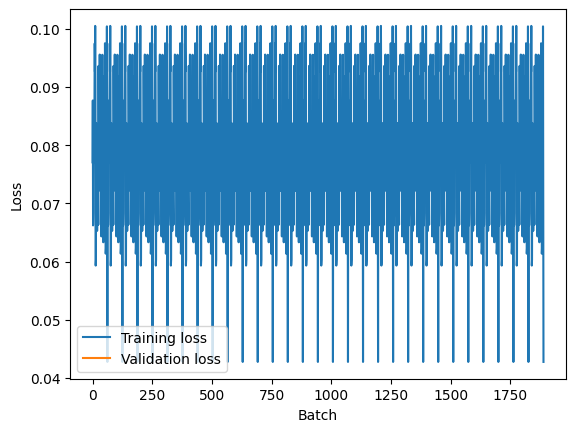

In [34]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])
plt.show()